In [1]:
# specify to reload any packages that are changed
# helps with not having to restart the kernel each time
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import copy
import corner 
import jax
import os
import scarlet
print(scarlet.__file__)
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping,AsinhPercentileNorm,show_scarlet2_scene,LinearPercentileNorm
import glob
import sep
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import numpyro.distributions as dist
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.wcs import WCS
from scarlet.source import StaticSource,MultiExtendedSource, StaticMultiExtendedSource
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import distrax
import optax
from tqdm.auto import tqdm
import pandas as pd
from numpyro.distributions import constraints
import cmasher as cmr
from scarlet2 import *
import scarlet2
from skimage import draw
print(scarlet2.__file__)
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

/home/cw1074/HSC/pulsars/scarlet/scarlet/__init__.py


/home/cw1074/.conda/envs/scarlet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/cw1074/scarletmultisource/scarlet2/scarlet2/__init__.py


In [3]:
def set_plot_style(doit=True,serif=True,use_tex=True):
    from matplotlib import cycler
    new_rcparams = {
        # Set color cycle: blue, green, yellow, red, violet, gray
        #'#axes.prop_cycle' : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set color cycle: blue, orange, green, red, violet, gray
        'axes.prop_cycle' : cycler('color', ['0C5DA5', 'FF9500', '00B945', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set default figure size
        'figure.figsize' : (4*1.5, 3*1.5),
        # Set x axis
        'xtick.direction' : 'in',
        'xtick.major.size' : 3*2,
        'xtick.major.width' : 0.5,
        'xtick.minor.size' : 1.5*2,
        'xtick.minor.width' : 0.5,
        'xtick.minor.visible' : True,
        'xtick.top' : True,
        # Set y axis
        'ytick.direction' : 'in',
        'ytick.major.size' : 3*2,
        'ytick.major.width' : 0.5,
        'ytick.minor.size' : 1.5*2,
        'ytick.minor.width' : 0.5,
        'ytick.minor.visible' : True,
        'ytick.right' : True,
        # Set line widths
        'axes.linewidth' : 0.5,
        'grid.linewidth' : 0.5,
        'lines.linewidth' : 1.,
        # Remove legend' frame
        'legend.frameon' : True,
        # Always save as 'tight'
        'savefig.bbox' : 'tight',
        'savefig.pad_inches' : 0.05,
    }
    if use_tex:
        new_rcparams.update({
            # Use LaTeX for math formatting
            'text.usetex' : True,
            'text.latex.preamble' : r'\usepackage{amsmath}'
            })
    if serif:
        new_rcparams.update({
            # Use serif fonts
            'font.serif' : 'Times New Roman',
            'font.family' : 'serif',
            'mathtext.fontset' : 'dejavuserif',
            'legend.fontsize' : 'large',
            'xtick.labelsize' : 'x-large',
            'ytick.labelsize' : 'x-large',
            'axes.labelsize' : 'xx-large',
            })
    if doit:
        plt.rcParams.update(new_rcparams)
    else:
        return new_rcparams
set_plot_style()
plt.rcParams["font.family"] = "Serif"

Provide name and position of source, desired bands, and location of image data.

In [4]:
getphotometry = True
getgalaxySED = False
getoffset = True
ra = 149.72718
dec = 2.02325
bandall=['g','i','r']
SNR = 5
shifts = [0.0,0.05,0.2,0.5,0.75,1.0,1.5]
pixscale=5
shiftmultiple=5

for shift in shifts[4:5]:
    galSNratio = 2.0
    srcname = 'SNoff'+str(shift)+'_'+str(SNR)+'_'+str(galSNratio)
    bandall=['g','r','i']
src = srcname
datadir='../data/'
imagedir = datadir+'/'+src
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
plotdir = datadir+'/'+src+'/plots'
print(plotdir)
if not os.path.isdir(plotdir):
    os.mkdir(plotdir)

coord_transient = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')


/scratch/gpfs/cw1074/HSCdata/multiressingleshift_priorimage/SNoff0.75_5_2.0/plots


Define a function which stacks the images and performs source detection on the stack

In [5]:
def makeCatalog(observations, lvl=3, wave=True):
    normed_images = np.asarray([obs.data for obs in observations])
    interps = [scarlet.interpolation.interpolate_observation(obs, observations[0]) for obs in observations]
    interps = np.asarray(interps/np.sum(interps))
    detect_image = np.sum(interps,axis=(0,1))
    # Wavelet transform
    wave_detect = scarlet.Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect-bkg.globalback, 3, err=bkg.globalrms)
    background=[]
    bg_rms=[]
    for obs in observations:
        img = obs.data
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
            background.append(np.array([sep.Background(band).globalback for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
            background.append(sep.Background(img).globalback)
    return catalog, bg_rms, detect_image, background

For each band, obtain the science, weight and PSF images. Loop over each image and create scarlet1 and scarlet2 observation objects.

In [6]:
observations=[]
observations_sc2_old=[]
channels=[]
channels_sc2 =[]
channels_zeroed=[]
times=[]
zps =[]
norms=[]
for band in bandall:
    imageout=[]
    psfs=[]
    images = glob.glob(imagedir+'/'+srcname+'_lsst'+band+'_*highres*[0-9].fits')#glob.glob(imagedir+'/warps-HSC-'+band+'-*-pdr3_dud*/warp-*.fits')
    print(imagedir+'/'+srcname+'_lsst'+band+'_*highres*[0-9].fits')
    for i,fn in enumerate(images):
        matches = [images[i].rstrip('.fits')+'_epsf.fits']#glob.glob(imagedir+'/SN-lsst'+band+'*_epsf.fits')
        if len(matches)>0:
                imageout.append(fn)
                psfs.append(matches[0])

        for img,psf in zip(imageout,psfs):
            obs_hdu = fits.open(img)
            data_hsc = obs_hdu[0].data.byteswap().newbyteorder()
            N1, N2 = data_hsc.shape
            data_hsc = data_hsc.reshape(1, N1, N2)

    for ind,(img,psf) in enumerate(zip(imageout,psfs)):
        obs_hdu = fits.open(img)
        try:
            mjd = Time(img.strip('.fits').split('_')[-1],format='mjd').mjd#Time(obs_hdu[0].header['DATE-AVG'],format='isot',scale='utc').mjd
        except KeyError:
            print('No time')
            continue
        data_hsc = obs_hdu[0].data.byteswap().newbyteorder()
        N1, N2 = data_hsc.shape
        data_hsc = data_hsc.reshape(1, N1, N2)
        weight_hsc=np.ones(data_hsc.shape)
        wcs_hsc = WCS(obs_hdu[0].header)
        channel = [band+str(ind)]
        channel_sc2 = (band, str(ind)) 
        channels.append(band+str(ind))
        channels_sc2.append(channel_sc2)
        if mjd>56160:
            channels_zeroed.append(channel_sc2)
        psf_hsc0 = fits.open(psf)[0].data
        Np1, Np2 = psf_hsc0.shape
        p1,p2=psf_hsc0.shape
        psf_hsc = scarlet.ImagePSF(psf_hsc0)
        r=1
        
        obs_hsc = scarlet.Observation(data_hsc,
                wcs=wcs_hsc,
                psf=psf_hsc,
                channels=channel,
                weights=weight_hsc)
        observations.append(obs_hsc)
        times.append(mjd)
        obs_sc2 = scarlet2.Observation(jnp.asarray(data_hsc), jnp.asarray(weight_hsc), psf=scarlet2.ArrayPSF(jnp.asarray([psf_hsc0,])),channels=[channel_sc2],wcs=wcs_hsc)
        observations_sc2_old.append(obs_sc2)
        norms.append(AsinhPercentileNorm(data_hsc,percentiles=[1,95]))#norms.append(AsinhMapping(minimum=-1, stretch=5, Q=3))
epochs = np.asarray([obs.channels[0][0] for obs in observations])
bands0,inds0 = np.unique([obs.channels[0][0] for obs in observations],return_index=True)
bands = epochs[inds0]

model_psf = scarlet.GaussianPSF(sigma=0.7)
model_frame,offset = scarlet.Frame.from_observations(observations, coverage='intersection', model_psf=model_psf)
frame_psf_sc2 = scarlet2.GaussianPSF(0.7)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2_old),observations_sc2_old[0].data.shape[-1],observations_sc2_old[0].data.shape[-2])), psf=frame_psf_sc2, channels=channels_sc2,wcs=wcs_hsc)

print(channels_sc2,channels_zeroed)


/scratch/gpfs/cw1074/HSCdata/multiressingleshift_priorimage/SNoff0.75_5_2.0/SNoff0.75_5_2.0_lsstg_*highres*[0-9].fits


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/scratch/gpfs/cw1074/HSCdata/multiressingleshift_priorimage/SNoff0.75_5_2.0/SNoff0.75_5_2.0_lsstr_*highres*[0-9].fits
/scratch/gpfs/cw1074/HSCdata/multiressingleshift_priorimage/SNoff0.75_5_2.0/SNoff0.75_5_2.0_lssti_*highres*[0-9].fits
[('g', '0'), ('g', '1'), ('g', '2'), ('g', '3'), ('g', '4'), ('g', '5'), ('g', '6'), ('g', '7'), ('g', '8'), ('g', '9'), ('g', '10'), ('g', '11'), ('g', '12'), ('g', '13'), ('g', '14'), ('r', '0'), ('r', '1'), ('r', '2'), ('r', '3'), ('r', '4'), ('r', '5'), ('r', '6'), ('r', '7'), ('r', '8'), ('r', '9'), ('r', '10'), ('r', '11'), ('r', '12'), ('r', '13'), ('r', '14'), ('i', '0'), ('i', '1'), ('i', '2'), ('i', '3'), ('i', '4'), ('i', '5'), ('i', '6'), ('i', '7'), ('i', '8'), ('i', '9'), ('i', '10'), ('i', '11'), ('i', '12'), ('i', '13'), ('i', '14')] [('g', '0'), ('g', '1'), ('g', '3'), ('g', '5'), ('g', '6'), ('g', '9'), ('g', '11'), ('g', '14'), ('r', '0'), ('r', '1'), ('r', '2'), ('r', '3'), ('r', '5'), ('r', '6'), ('r', '8'), ('r', '13'), ('i', '1'), 

Run source detection to create a catalog of source positions. Subtract background from images.

In [7]:
lvl = 1
wave = 1
#Obtain source catalog and background flux estimation from our makeCatalog function
catalog_single, bgsingle, detectsingle, globalback = makeCatalog(observations, lvl, wave)
obssinglearr=np.asarray(observations)
bgsinglearr=np.asfarray(bgsingle)
pixel = np.stack((catalog_single['y'], catalog_single['x']), axis=1)
ra_dec = [obs.get_sky_coord(pixel) for obs in obssinglearr][0]
observations_sc2=[]
normsingle=[]
for ind,(obs,obs2,bg,back) in enumerate(zip(observations,observations_sc2_old,bgsingle,globalback)):
    #Reset weights based on background estimate (if needed)
    #obs.weights = np.ones(obs.shape) / (bg**2)[:, None, None]#(bg**2)[:, None, None]
    #Subtract background flux if needed
    #obs.data = obs.data-back
    #obs2.data = obs2.data - back
    obs_sc2 = scarlet2.Observation(jnp.asarray(obs.data), jnp.asarray(obs.weights), psf=scarlet2.ArrayPSF(jnp.asarray(obs.psf.get_model())),channels=[channels_sc2[ind]],wcs=wcs_hsc)
    observations_sc2.append(obs_sc2)
    #Store norm based on observation data
    normsingle.append(LinearPercentileNorm(obs.data,percentiles=[0.1, 99.9]))
    
for obs in observations_sc2:
    obs.match(model_frame_sc2)

Plot the first couple of images

(2, 2)


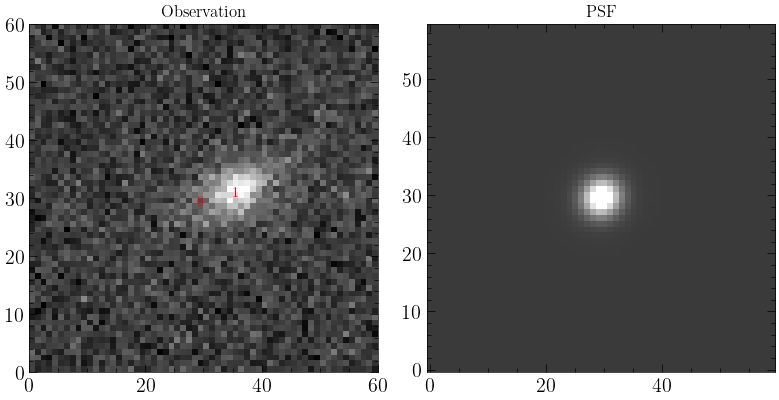

In [8]:
print(np.asarray(ra_dec).shape)
if np.asarray(ra_dec).shape==(2,):
    for ind,(obs, norm) in enumerate(zip(observations[:1], normsingle[:1])):
        scarlet.display.show_observation(obs, norm=norm, sky_coords=[ra_dec], show_psf=True)
else:    
    for ind,(obs, norm) in enumerate(zip(observations[:1], normsingle[:1])):
        scarlet.display.show_observation(obs, norm=norm, sky_coords=ra_dec, show_psf=True)
    

In [9]:
if np.asarray(ra_dec).shape==(2,):
    separ=[0]
    indtransient=0
else:
    c2 = [SkyCoord(ra*u.deg,dec*u.deg,frame='icrs') for ra,dec in ra_dec]
    separ = [coord_transient.separation(c).arcsecond for c in c2]
    indtransient = np.argmin(separ)

In [10]:
epochs = np.asarray([obs.channels[0][0] for obs in observations])
bands0,inds0 = np.unique([obs.channels[0][0] for obs in observations],return_index=True)
bands = epochs[inds0]
bandind = [np.argwhere(bands==e)[0][0] for e in epochs]

Define the scarlet2 PSF model and model frame. Match the model frame to the observations.

In [11]:
frame_psf_sc2 = scarlet2.GaussianPSF(0.7)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),observations_sc2[0].data.shape[-2],observations_sc2[0].data.shape[-1])), psf=frame_psf_sc2, channels=channels_sc2,wcs=wcs_hsc)

for obs in observations_sc2:
    obs.match(model_frame_sc2)

Initialize scarlet2 sources 

In [12]:
from galaxygrad import HSC_ScoreNet64, ZTF_ScoreNet64

stepnum=600
gal_step = 2e-3
AGN_step = 2e-3
from scarlet2 import nn
model_size = 64

prior = nn.ScorePrior(
            model=HSC_ScoreNet64
        )
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,pos in enumerate(ra_dec):      
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asfarray(observations_sc2_old[0].frame.wcs.world_to_pixel(coord))
        center = jnp.asarray(np.asfarray([pos[0],pos[1]]))
        centerpix = jnp.asarray([pospix[1],pospix[0]])
        print(ra_dec.shape,'CENTER',center,centerpix)
        if i==indtransient:    
            flux = initialization.pixel_spectrum(observations_sc2, center)
            flux = jnp.asarray(np.asarray(flux)[:,0]) 
            print(flux)
           
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])

            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            AGN_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_agn =1e-3*peak_value2

            scarlet2.PointSource(
                    centerpix,
                    scarlet2.TransientArraySpectrum(Parameter(jnp.asarray(flux), stepsize=AGN_step, constraint=constraints.positive), epochs = channels_zeroed)#,constraint = scarlet2.PositiveConstraint())
                )
            if ra_dec.shape[0]==1:
                flux = initialization.pixel_spectrum(observations_sc2, center)
                flux = jnp.asarray(np.asarray(flux)[:,0][inds0]) 
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center) + 1e-6
                print('Making host at position of transient',flux,np.min(morph_init))
                morph_init[morph_init<1e-12] = 1e-12
                n_steps, peak_value = stepnum, 1

                schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
                morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)#lambda p, it: scarlet2.relative_step(p, factor=2e-3) * schedule(it)
                
                test_step_morph =2e-3*peak_value
                n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])


                schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
                gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)#lambda p, it: scarlet2.relative_step(p, factor=2e-3) * schedule(it)
                test_step_gal =5e-3*peak_value2
                scarlet2.Source(
                    center,
                    scarlet2.StaticArraySpectrum(Parameter(jnp.asarray(flux), stepsize=gal_step,constraint=constraints.positive),filters=bandall),scarlet2.ArrayMorphology(Parameter(morph_init, stepsize=morph_step, constraint=constraints.positive, prior=prior)))
                   
        else:
            
            flux = jnp.asarray(np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0])
            morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center) + 1e-12
            print('Making other galaxy',flux,np.sum(np.isnan(morph_init)))
           
            morph_init = jnp.asarray(morph_init)
            n_steps, peak_value = stepnum, 1
           
            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])
            
    
            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_gal =5e-3*peak_value2

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(Parameter(jnp.asarray(flux), stepsize=gal_step,constraint=constraints.positive),filters=bandall),scarlet2.ArrayMorphology(Parameter(morph_init, stepsize=morph_step, constraint=constraints.positive, prior=prior)))
               
scene.set_spectra_to_match(observations_sc2)

(2, 2) CENTER [149.7272      2.0232248] [29.46838  29.522345]
[0.04362802 0.17943773 0.11348891 0.56736    0.13317062 0.09586278
 0.6749642  0.10064656 0.14317301 0.15633723 0.02998608 0.2397528
 0.11492445 0.12748902 0.8211189  1.1501058  1.1939329  0.41847825
 0.7702832  0.05624187 0.253577   0.2939913  0.05624297 1.6370231
 0.21313463 0.10415138 0.10214875 0.07993264 0.3909439  0.17746867
 0.1664417  0.40126523 0.18776129 0.16412085 1.6465487  0.10389999
 0.21481784 0.60405326 1.4191699  0.73839855 0.32845283 1.1187357
 0.13524285 0.1932241  0.9813735 ]
(2, 2) CENTER [149.72691     2.0232923] [30.89557 35.60716]
Making other galaxy [0.3786463  0.64233094 0.72102314] 0


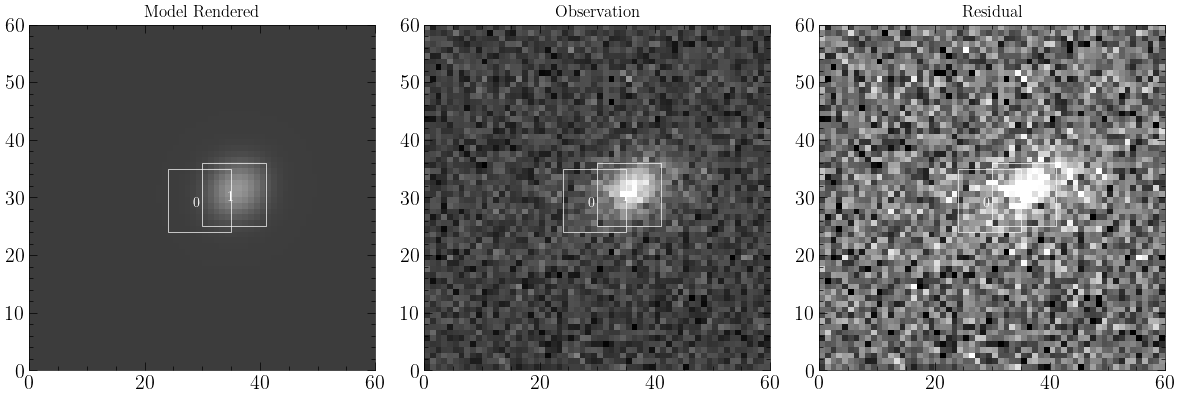

In [13]:
scarlet2.plot.scene(
    scene,
    observation=observations_sc2[10],
    norm=normsingle[10],
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()

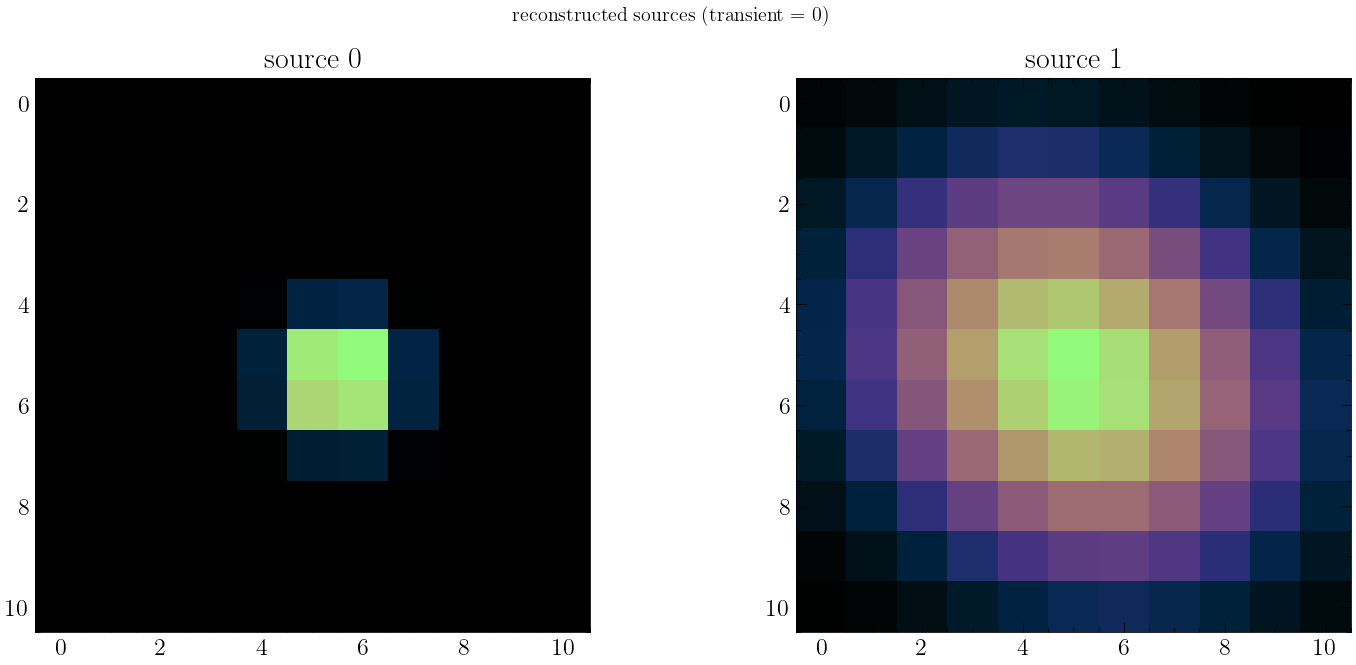

<Figure size 600x450 with 0 Axes>

In [14]:
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene.sources[i].morphology()
    else:
        y = scene.sources[i].morphology.data
    ax.imshow(y, cmap = cmap,interpolation=int_method,vmin = 0)#np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.show()
plt.clf()

In [15]:
n_steps, peak_value_pos = stepnum, 1
schedulepos = optax.cosine_onecycle_schedule(n_steps, peak_value_pos, final_div_factor=1)
pos_step = lambda p: scarlet2.relative_step(p, factor=1e-3)#lambda p, it: scarlet2.relative_step(p, factor=0.01) * schedule(it)
flux = scene.sources[indtransient].spectrum.data
print(flux)

scene.set_info('sources.'+str(indtransient)+'.morphology.center', fixed=False,stepsize = pos_step)#, prior=dist.Normal(scene.sources[indtransient].morphology.center, 0.5))
scene_ = scene.fit(observations_sc2, max_iter=n_steps, e_rel=1e-8,schedule=schedulepos)
flux = scene_.sources[indtransient].spectrum.data
print(flux)


[0.04362802 0.17943773 0.11348891 0.56736    0.13317062 0.09586278
 0.6749642  0.10064656 0.14317301 0.15633723 0.02998608 0.2397528
 0.11492445 0.12748902 0.8211189  1.1501058  1.1939329  0.41847825
 0.7702832  0.05624187 0.253577   0.2939913  0.05624297 1.6370231
 0.21313463 0.10415138 0.10214875 0.07993264 0.3909439  0.17746867
 0.1664417  0.40126523 0.18776129 0.16412085 1.6465487  0.10389999
 0.21481784 0.60405326 1.4191699  0.73839855 0.32845283 1.1187357
 0.13524285 0.1932241  0.9813735 ]


100%|██████████| 600/600 [00:37<00:00, 15.89it/s, loss=149106.36, max_change=0.000054]


[0.49655497 1.0735915  0.11348891 2.9768262  0.13317063 0.7867876
 4.184405   0.10064655 0.14317301 1.1333809  0.02998608 1.6878961
 0.11492445 0.12748902 4.9500003  6.484683   6.835929   1.4313792
 3.9697897  0.05624187 1.2516432  1.3151398  0.05624296 9.138434
 0.21313465 0.10415137 0.10214876 0.07993264 2.0543575  0.17746866
 0.1664417  2.0022326  0.1877613  0.16412085 8.627226   0.10389998
 0.21481785 2.8190355  7.6123943  3.7440434  1.3033869  5.865099
 0.13524283 0.1932241  5.0970902 ]


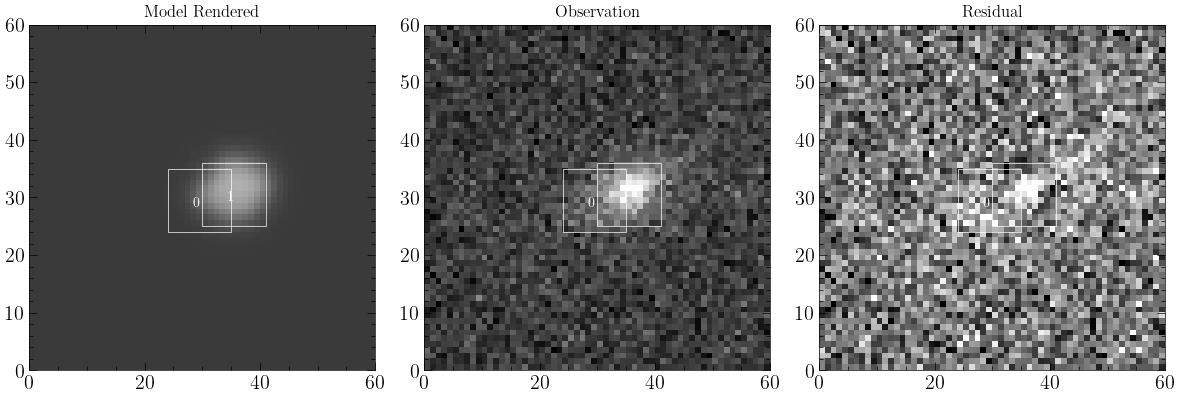

In [16]:
scarlet2.plot.scene(
    scene_,
    observation=observations_sc2[0],
    norm=normsingle[0],
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    #figsize=None,
    linear=True,
)
plt.show()

In [17]:
scene_.set_info(scene_.parameters.keys(), fixed=True) 

print(scene_.sources[indtransient].morphology.center)
print(dist.Normal(scene_.sources[indtransient].morphology.center, 0.01).sample(jax.random.PRNGKey(0),(10,)))
scene_.set_info('sources.'+str(indtransient)+'.morphology.center', fixed=False, prior=dist.Normal(scene_.sources[indtransient].morphology.center, 5.0),stepsize=pos_step)

#%debug
mcmc = scene_.sample(observations_sc2,num_warmup=150, num_samples=300) 
q = mcmc.get_samples()['sources.'+str(indtransient)+'.morphology.center'] 
q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
print(q1)
centerAGN = np.asfarray([q1[2,0],q1[2,1]])
errorAGN = np.asarray([np.abs(q1[4,0]-q1[0,0]),np.abs(q1[4,1]-q1[0,1])])
print(centerAGN,errorAGN)
corner.corner(mcmc).show() 
plt.savefig(plotdir+'/'+srcname+'_transientcenter_corner.png')
plt.show()
plt.clf()


[29.436949 29.478968]
[[29.447495 29.469275]
 [29.431004 29.47865 ]
 [29.461058 29.460184]
 [29.429102 29.47583 ]
 [29.440287 29.496645]
 [29.426672 29.49308 ]
 [29.431864 29.473703]
 [29.44198  29.489517]
 [29.436075 29.486925]
 [29.463514 29.473145]]


RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [ ]:
complc = np.loadtxt('/scratch/gpfs/cw1074/HSCdata/multiressingleshift_priorimage/SNoff1.5_5_2.0_lc.txt',dtype=str)
lcbands= [x[-1] for x in complc[:,1]]
fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
print(fac)
times=np.asarray(times)
summed_diff = 0
for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
    plt.scatter(times[epochs==b]-57700+1550,flux[epochs==b]*fac,linestyle='',label=b,color=c,marker='.')
    indb = np.argwhere(np.asarray(lcbands)==b)[:,0]
    summed_diff+=np.sum(np.abs(flux[epochs==b]-np.asfarray(complc[:,2])[indb]))
    plt.scatter(np.asfarray(complc[:,0])[indb]-57700+1550,np.asfarray(complc[:,2])[indb],label=b+'-sim',color=c,marker='x')
print('summed diff',summed_diff)
plt.xlabel('MJD-56150')
plt.xlim((0,100))
plt.ylabel('Flux')
plt.legend()
plt.savefig(plotdir+'/'+srcname+'_lc_flux_nonparametric.png')
print('Saved',plotdir+'/'+srcname+'_lc_flux_nonparametric.png')
plt.show()

getphotometry=False
if getphotometry==True:
    scene_.set_info(scene_.parameters.keys(), fixed=True)
    #priorspec = np.maximum([0.1*scene_.sources[indtransient].spectrum.data],[bg])
    #print([0.1*scene_.sources[indtransient].spectrum.data],[bg],priorspec)
    print(scene_.sources[indtransient].spectrum.data, 0.1*scene_.sources[indtransient].spectrum.data)#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5)
    scene_.set_info('sources.'+str(indtransient)+'.spectrum.data', fixed=False, prior=dist.Normal(scene_.sources[indtransient].spectrum.data, np.clip(0.02*scene_.sources[indtransient].spectrum.data,a_min=1,a_max=200)))#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))##01scene.sources[5].spectrum.data))#dist.Uniform(scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2)) 
    scene_.set_info('sources.'+str(indtransient)+'.morphology.center', fixed=False, prior=dist.Normal(scene_.sources[indtransient].morphology.center, 4.0))

    mcmc = scene_.sample(observations_sc2,num_warmup=100, num_samples=300) 
    q = mcmc.get_samples()['sources.'+str(indtransient)+'.spectrum.data'] 
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1)) 
    fluxes = [] 
    fluxerrors = [] 
    for i,b in zip(range(q1.shape[1]),bandind): 
        print(i,'median = ',q1[2][i],'std = ',(q1[4][i]-q1[0][i])/2) 
        fluxes.append(q1[2][i]*fac) 
        fluxerrors.append(np.abs(q1[4][i]-q1[0][i])/2*fac)

    mcmc.print_summary() 
    '''
    q = mcmc.get_samples()['sources.'+str(indtransient)+'.morphology.center'] 
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
    print(q1)
    centerAGN = np.asfarray([q1[2,0],q1[2,1]])
    errorAGN = np.asarray([np.abs(q1[4,0]-q1[0,0]),np.abs(q1[4,1]-q1[0,1])])
    '''

    zps = np.asfarray(zps)
    fluxes = np.asfarray(fluxes)
    fluxerrors = np.asfarray(fluxerrors)
    times=np.asfarray(times)


    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
    
    for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
        indb = np.argwhere(np.asarray(lcbands)==b)[:,0]
        plt.errorbar(times[epochs==b]-57700+1550,fluxes[epochs==b],yerr = fluxerrors[epochs==b],linestyle='',label=b+'-scarlet',color=c,marker='.',ecolor='gray')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
        plt.scatter(np.asfarray(complc[:,0])[indb]-57700+1550,np.asfarray(complc[:,2])[indb],label=b+'-sim',color=c,marker='x')
    
    plt.xlabel('MJD-56150')
    plt.xlim((0,100))
    #plt.xlim((0,300))
    #plt.ylim((22.0,22.3))
    plt.ylabel('Flux')
    plt.legend()
    #plt.title(srcname)
    plt.savefig(plotdir+'/'+srcname+'_lc_flux_nonparametric.pdf')
    plt.show()
    plt.clf()
    outlchead=['MJD','FLUX','FLUXERR','BAND']
    outlc=np.column_stack((times,fluxes,fluxerrors,epochs))
    outlc = np.vstack((outlchead,outlc))
    np.savetxt(plotdir+'/lc.txt',np.asarray(outlc,dtype=str),fmt='%s')
    sed=[]
    sederr=[]
    print(bandall)
    for b,c in zip(bandall,['green','orange','red','purple','blue']):
        indb = np.argwhere(np.asarray(lcbands)==b)[:,0]
        sed.append(np.mean(fluxes[epochs==b]))
        sederr.append(np.std(fluxes[epochs==b]))
        plt.errorbar(times[epochs==b]-57700+1550,25-2.5*np.log10(fluxes[epochs==b]),yerr = 1.0857*np.abs(fluxerrors[epochs==b]/fluxes[epochs==b]),ecolor='gray',linestyle='',label=b+'-scarlet',color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
        plt.scatter(np.asfarray(complc[:,0])[indb]-57700+1550,25-2.5*np.log10(np.asfarray(complc[:,2])[indb]),label=b+'-sim',color=c,marker='x')
 
    plt.xlabel('MJD-56150')
    plt.xlim((0,100))
    #plt.xlim((0,300))
    print(25-2.5*np.log10(np.sqrt(3*bg)))
    plt.ylim((19.8,24))
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_lc_mag_nonparametric.pdf')
    print('Saved',plotdir+'/'+srcname+'_lc_mag_nonparametric.pdf')
    plt.show()


In [ ]:
channels = np.asarray(channels)
observations_sc2_arr = np.asarray(observations_sc2)
normsinglearr = np.asarray(normsingle)
for i,(chan,obs,obs1,norm) in enumerate(zip(channels[inds0],observations_sc2_arr[inds0],obssinglearr[inds0],normsinglearr[inds0])):
        model_ = obs.render(scene_())
        scarlet.display.show_scarlet2_scene(sources,
                           norm=normsinglearr[1],#norm,
                           observation=obs,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, coverage='intersection', model_psf=model_psf)[0],
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )
        plt.savefig(plotdir+'/scarlet2fit'+chan+'.png')
        plt.show()
        plt.clf()

In [ ]:
makelc = True
if makelc:
    scene_.set_info(scene_.parameters.keys(), fixed=True)
    scene_.set_info('sources.'+str(indtransient)+'.spectrum.data', fixed=False, prior=dist.Normal(scene_.sources[indtransient].spectrum.data, 0.01*np.clip(scene_.sources[indtransient].spectrum.data,a_min=1e-5,a_max=1e6)))#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))##01*scene.sources[5].spectrum.data))#dist.Uniform(scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2))
    fluxes = []
    fluxerrors = []
    for indflux,obs2 in enumerate(observations_sc2):
        mcmc = scene_.sample(obs2,num_warmup=50, num_samples=100)
        q = mcmc.get_samples()['sources.'+str(indtransient)+'.spectrum.data']
        print(q.shape)
        q = q[indflux]
        q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0)
        fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))

        print(i,'median = ',q1[2],'std = ',(q1[3]-q1[1])/2)
        fluxes.append(q1[2]*fac)
        fluxerrors.append((q1[3]-q1[1])/2*fac)
        print(fluxes,fluxerrors)
    mcmc.print_summary()
    for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
        plt.scatter(times[epochs==b]-57700,flux[epochs==b],linestyle='',label=b,color=c,marker='.')
        indb = np.argwhere(np.asarray(lcbands)==b)[:,0]
        summed_diff+=np.sum(np.abs(flux[epochs==b]-np.asfarray(complc[:,2])[indb]))
        plt.scatter(np.asfarray(complc[:,0])[indb]-57700,np.asfarray(complc[:,2])[indb],label=b+'-sim',color=c,marker='x')
    print('summed diff',summed_diff)
    plt.xlabel('MJD-57700')
    #plt.xlim((0,300))
    #plt.ylim((22.0,22.3))
    plt.ylabel('Flux')
    plt.legend()
    plt.title(srcname)
    plt.savefig(plotdir+'/'+srcname+'_lc_flux_witherrrors_sersic.png')
    plt.show()


In [ ]:
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene_.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene_.sources[i].morphology()
    else:
        y = scene_.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,vmin = np.max([np.min(np.log(y)[np.log(y)>-50]),-50]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.savefig(plotdir+'/'+srcname+'_reconstructed_sources.png')
plt.show()
plt.clf()

In [ ]:

fig, axes = plt.subplots(1, len( scene_.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = scene_.sources[i].morphology() 
    ax.imshow(y, cmap = cmap, vmin=np.min(y), vmax=np.max(y)*0.5, interpolation=int_method) 
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
#plt.suptitle('reconstructed sources', fontsize=24,y=0.75)
plt.show()
plt.clf()

In [ ]:
for i,(chan,obs,norm) in enumerate(zip(channels[inds0],observations_sc2_arr[inds0],normsinglearr[inds0])):
        model_ = obs.render(scene_())
        scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           model = model_,
                           frame = model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           add_labels=False,
                           figsize=(8,3)
                          )
        plt.savefig(plotdir+'/scarlet2fit'+chan+'.pdf')
        plt.show()
        plt.clf()
for i,(chan,obs,norm) in enumerate(zip(channels[inds0+12],observations_sc2_arr[inds0+12],normsinglearr[inds0+12])):
        model_ = obs.render(scene_())
        scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           model = model_,
                           frame = model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           add_labels=False,
                           figsize=(8,3)
                          )
        plt.savefig(plotdir+'/scarlet2fit'+chan+'.pdf')
        plt.show()
        plt.clf()

In [ ]:
getgalaxySED=True
if getgalaxySED==True:
    wave = [4754,7711,6175]
    out = np.column_stack((wave,scene_.sources[indtransient+1].spectrum.data))
    fac = np.sum(scene_.sources[indtransient+1].morphology.data,axis=(-2,-1))
    galquick = scene_.sources[indtransient+1].spectrum.data *fac
    np.savetxt(plotdir+'/sed_quick.txt',np.asarray(out,dtype=str),fmt='%s')
    plt.scatter(wave,scene_.sources[indtransient+1].spectrum.data,marker='.',linestyle='',label='Host galaxy')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_SED_GAL_quick.png')
    plt.show()
    plt.clf()
    scene_.set_info(scene_.parameters.keys(), fixed=True)
    print(scene_.sources[indtransient+1].spectrum.data)
    scene_.set_info('sources.'+str(indtransient+1)+'.spectrum.data', fixed=False, prior=dist.Normal(np.clip(scene_.sources[indtransient+1].spectrum.data,a_min=bgsingle[0],a_max=1e6), 0.02*np.clip(scene_.sources[indtransient+1].spectrum.data,a_min=bgsingle[0]*5,a_max=1e6)))#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))##01*scene.sources[5].spectrum.data))#dist.Uniform(scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2))
    scene_.set_info('sources.'+str(indtransient)+'.spectrum.data', fixed=False, prior=dist.Normal(scene_.sources[indtransient].spectrum.data, np.clip(0.02*scene_.sources[indtransient].spectrum.data,a_min=1,a_max=200)))
    mcmc = scene_.sample(observations_sc2,num_warmup=100, num_samples=200)
    q = mcmc.get_samples()['sources.'+str(indtransient+1)+'.spectrum.data']
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0)
    fac = np.sum(scene_.sources[indtransient+1].morphology.data,axis=(-2,-1))
    galfluxes = []
    galfluxerrors = []
    for i,b in zip(range(q1.shape[1]),bandind):
        print(i,'median = ',q1[2][i],'std = ',(q1[4][i]-q1[0][i])/2)
        galfluxes.append(q1[2][i]*fac)
        galfluxerrors.append((q1[3][i]-q1[1][i])/2*fac)
    mcmc.print_summary()

    corner.corner(mcmc).show()
    plt.savefig(plotdir+'/'+srcname+'_galflux_corner.png')
    plt.show()
    plt.clf()
    sedgal = np.asfarray(galfluxes)
    sedgalerr = np.asfarray(galfluxerrors)
   
    print(2.5*np.log10(63095734448.01944/sedgal))
    plt.errorbar(wave,sedgal,yerr=sedgalerr,marker='.',linestyle='',label='Host galaxy')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_SED_GAL.png')
    plt.show()
    plt.clf()
    outsedhead=['WAVE_CEN','GALFLUX','GALFLUXERR']
    outsed=np.column_stack((wave,sedgal,sedgalerr))
    outsed = np.vstack((outsedhead,outsed))
    np.savetxt(plotdir+'/sed.txt',np.asarray(outsed,dtype=str),fmt='%s')